# a2-xarray-handbook

## goal - document the xarray build process single band

1. build a numpy array - container of the right window size
2. read the bucket s3 geotiff with dask - lazy load
3. window the full scene into the pre-sized numpy array container

In [1]:
# what s the image
redfile = 's3://lsaa-staging-cog/L08/2014/042/034/LC08_L2SP_042034_20140115_20171310_01_A1/LC08_L2SP_042034_20140115_20171310_01_A1_sr_band4.TIF'

In [2]:
print(redfile)

s3://lsaa-staging-cog/L08/2014/042/034/LC08_L2SP_042034_20140115_20171310_01_A1/LC08_L2SP_042034_20140115_20171310_01_A1_sr_band4.TIF


In [3]:
import rasterio
with rasterio.open(redfile) as src:
    print(src.crs)

PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]


In [4]:
from lilcubeLib.lc_geometry import bounding_box_tuple_from_geojson
from lilcubeLib.lc_xarray import AOI_bounding_box, build_the_xarray


def get_geo_box(aoi_geojson_file_name):
    bbox = bounding_box_tuple_from_geojson(aoi_geojson_file_name)
    aoi = AOI_bounding_box((bbox[0][0], bbox[0][1], bbox[1][0], bbox[1][1]))
    return(aoi)

In [5]:
aoi_file = 'pine_lake.geojson'
g_aoi = get_geo_box(aoi_file)

[[[-119.35272216796874, 36.81808022778526], [-119.2510986328125, 36.81808022778526], [-119.2510986328125, 36.91915611148194], [-119.35272216796874, 36.91915611148194], [-119.35272216796874, 36.81808022778526]]]
H: (-119.35272216796874, 36.91915611148194, -119.2510986328125, 36.81808022778526)


In [6]:
dir(g_aoi)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'bounding_box',
 'geobox',
 'lr_lat',
 'lr_lon',
 'ul_lat',
 'ul_lon']

In [7]:
print(g_aoi.ul_lon, g_aoi.ul_lat)
print(g_aoi.lr_lon, g_aoi.lr_lat)


-119.35272216796874 36.91915611148194
-119.2510986328125 36.81808022778526


In [8]:
print(g_aoi.bounding_box)

{'left': -119.35272216796874, 'right': -119.2510986328125, 'top': 36.91915611148194, 'bottom': 36.81808022778526}


In [9]:
print(g_aoi.geobox)

GeoBox(Geometry({'type': 'Polygon', 'coordinates': [[(-119.34699055634248, 36.79896498479334), (-119.3833631301185, 36.91323557670854), (-119.25706261511006, 36.938148035840456), (-119.22087054440304, 36.82384084291261), (-119.34699055634248, 36.79896498479334)]]}, CRS('EPSG:4326')))


In [10]:
print(g_aoi.geobox.width)

383


In [11]:
print(g_aoi.geobox.height)

440


In [12]:
print(g_aoi.geobox.shape)

(440, 383)


In [13]:
print(g_aoi.geobox.geographic_extent)

Geometry({'type': 'Polygon', 'coordinates': [[(-119.34699055634248, 36.79896498479334), (-119.3833631301185, 36.91323557670854), (-119.25706261511006, 36.938148035840456), (-119.22087054440304, 36.82384084291261), (-119.34699055634248, 36.79896498479334)]]}, CRS('EPSG:4326'))


In [14]:
bb = g_aoi.geobox.geographic_extent.boundingbox

In [15]:
print(bb)


BoundingBox(left=-119.3833631301185, bottom=36.79896498479334, right=-119.22087054440304, top=36.938148035840456)


In [16]:
from lilcubeLib.lc_geometry import *
ep = 'epsg:5072'

ul = (bb.top, bb.left)
lr = (bb.bottom, bb.right)

ulx,uly = geo_translate(ul[0],ul[1],epsg=ep)
row1,col1 = src.index(ulx,uly)
lrx,lry = geo_translate(lr[0],lr[1],epsg=ep)
row2,col2 = src.index(lrx, lry)


In [17]:
print(row1,row2)
print(row2 - row1)

6081 6701
620


In [18]:
print(col1,col2)
print(col2 - col1)

2809 3147
338


In [19]:
from osgeo import ogr
import json;

def cool_code(filename):
   
    with open (filename, "r") as myfile:
        data=myfile.read()

    dataset = json.loads(data)

    for f in dataset["features"]:
        c = f["geometry"]["coordinates"][0]
        c1 = [x[0] for x in c] # first coordinate
        c2 = [x[1] for x in c]
        bbox = [[min(c1),min(c2)],[min(c1),max(c2)],[max(c1),max(c2)],[max(c1),min(c2)],[min(c1),min(c2)]]
        f["geometry"]["coordinates"] = [bbox]
        ul = ([max(c1), max(c2)])
        lr = ([min(c1), min(c2)])

    # with open("yourOutputFile.geojson","w") as f:
        # json.dump(dataset,f)
    return(ul,lr)

In [20]:
ul,lr = cool_code(aoi_file)

In [21]:
ul

[-119.2510986328125, 36.91915611148194]

In [22]:
lr

[-119.35272216796874, 36.81808022778526]

In [23]:
print(g_aoi.ul_lon, g_aoi.ul_lat)
print(g_aoi.lr_lon, g_aoi.lr_lat)

-119.35272216796874 36.91915611148194
-119.2510986328125 36.81808022778526


In [24]:
ul = (g_aoi.ul_lon, g_aoi.ul_lat)
lr = (g_aoi.lr_lon, g_aoi.lr_lat)
type(g_aoi.ul_lon)

float

In [25]:
ul,lr

((-119.35272216796874, 36.91915611148194),
 (-119.2510986328125, 36.81808022778526))

In [26]:
type(ul[0])

float

In [27]:
ep = "epsg:5072"

ulx,uly = geo_translate(ul[0],ul[1],epsg=ep)

In [28]:
ulx,uly

(1e+30, 1e+30)

In [29]:
ulx,uly = geo_translate(ul[1],ul[0],epsg=ep)
row1,col1 = src.index(ulx,uly)
lrx,lry = geo_translate(lr[1],lr[0],epsg=ep)
row2,col2 = src.index(lrx, lry)

In [30]:
print(row2 - row1)

439


In [31]:
print(col2 - col1)

198


In [32]:
ul = (bb.top, bb.left)
lr = (bb.bottom, bb.right)
ul,lr

((36.938148035840456, -119.3833631301185),
 (36.79896498479334, -119.22087054440304))

In [33]:
print (row1,row2)

6171 6610


In [34]:
print (col1,col2)

2879 3077


In [35]:
import xarray
geoTiff = redfile
xchunk = 2048
ychunk = 2048
da = xarray.open_rasterio(geoTiff, chunks={'band': 1, 'x': xchunk, 'y': ychunk})


In [36]:
my_raster = da.sel(band=1)
holding_tank = my_raster[row1:row2, col1:col2]

In [37]:
type(holding_tank)

xarray.core.dataarray.DataArray

In [38]:
holding_tank.shape

(439, 198)

In [39]:
import matplotlib
from matplotlib import pyplot

pyplot.imshow(holding_tank, cmap='gray')
pyplot.show()

<Figure size 640x480 with 1 Axes>

In [40]:
ul = (bb.top, bb.left)
lr = (bb.bottom, bb.right)

ulx,uly = geo_translate(ul[0],ul[1],epsg=ep)
row1,col1 = src.index(ulx,uly)
lrx,lry = geo_translate(lr[0],lr[1],epsg=ep)
row2,col2 = src.index(lrx, lry)

In [41]:
import xarray
geoTiff = redfile
xchunk = 2048
ychunk = 2048
da = xarray.open_rasterio(geoTiff, chunks={'band': 1, 'x': xchunk, 'y': ychunk})

my_raster = da.sel(band=1)
holding_tank = my_raster[row1:row2, col1:col2]

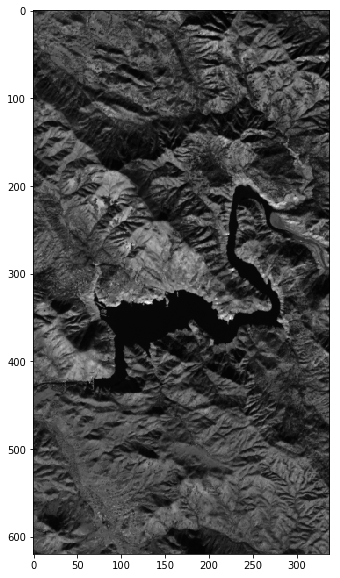

In [42]:


figsize=[6,6]
pyplot.figure(figsize=(8,10))

pyplot.imshow(holding_tank, cmap='gray')

pyplot.show()

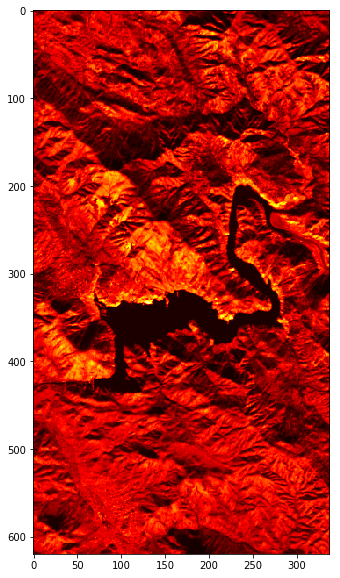

In [43]:
figsize=[6,6]
pyplot.figure(figsize=(8,10))

pyplot.imshow(holding_tank, cmap='hot')

pyplot.show()

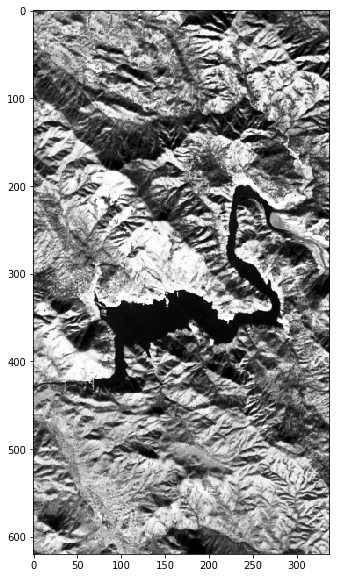

In [44]:
from skimage import exposure
import numpy as np

w = holding_tank.values

img_toshow = exposure.equalize_hist(w)
pyplot.figure(figsize=(8,10))
pyplot.imshow(img_toshow, cmap='gray')

In [45]:

from noteLib import geo*




SyntaxError: invalid syntax (<ipython-input-45-445861a5a215>, line 2)